# Cancer Detection - CNN Model


A CNN Model

A deep learning project 



### Overview:

Cancer is a highly researched area because there are so many people who suffer and/or die of cancerous disease. This study aims to improve cancer detection in lymph nodes by using computer vision machine learning technqiues. We will examine the data given in this competition to get a better understanding of it. Then, we will run multiple convolutional neural network models with the intent to be able to classify cancerous and non-cancerous cells. 

This notebook covers the thought process as to how to create simple CNN models. We will create two models, one without hyperparameter tuning, and one with tuning. Finally, we will suggest ways to improve the models in future studies.

#### Following layouts:

* Brief Description of the Problem and Data
* Exploratory Data Analysis (EDA) - Inspect, Visualize and Clean the Data
* Describe Model Architecture
* Results and Analysis
* Conclusion

In [1]:
# Imports libraries:

import numpy as np
import pandas as pd
import os
import random
import cv2
import shutil

from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix

# for image:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import matplotlib.image as mpimg
from skimage.filters import gaussian
from skimage.util import random_noise
from skimage.transform import rotate
from skimage import io

# for model:
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D

from tensorflow.keras.optimizers import Adam

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# Check tensorflow verison:

tf.__version__

'2.6.4'

## Brief Description of the Problem and Data:

This data contains thousands of small images where the 96x96 pixel images with 3 channels, each with an identifying label and id. 

We have two datasets, a training and testing set already split for us. The training set contains 220,025 unique images and the test set contains about 57,500. To use these images in a machine learning model, we are also given an identifying dataframe with two columns: 'id' which is the unique image ID correpsonding to the training directory, and 'label' which tells us the classification category. Each label is either a 0 or 1, depending whether the image is non-cancerous or cancerous. 

In the competition description, we find that if at least one pixel of an image is identified as cancerous then the whole image is therefore marked with a 1, otherwise it is 0. It is important to note that we do not have any missing values in this data which will make preprocessing more efficient.

In [3]:
# Get global path:

dir_list = os.listdir('../input/histopathologic-cancer-detection/')
dir_list

['sample_submission.csv', 'train_labels.csv', 'test', 'train']

In [4]:
# Set paths:

train = '../input/histopathologic-cancer-detection/train/'
test = '../input/histopathologic-cancer-detection/test/'

data_train = pd.read_csv('../input/histopathologic-cancer-detection/train_labels.csv')

In [5]:
# Dimensions:

print(len(os.listdir(train)))
print(len(os.listdir(test)))

220025
57458


In [6]:
# Get image paths:

print(os.listdir(train)[:5])
print(os.listdir(test)[:5])

['d43c081bafa286f9c1f7e921883f26ceafebc912.tif', '092d0eedebce504847715ee046b6ad74b57599b4.tif', 'b0d2582c6218a8764323fc940b41312282b99bf4.tif', '187c99df762f13f99818e5593d4bab4c6577e7e3.tif', '7c5270c83837de5a5cbb2dca511559dc39d19d53.tif']
['a7ea26360815d8492433b14cd8318607bcf99d9e.tif', '59d21133c845dff1ebc7a0c7cf40c145ea9e9664.tif', '5fde41ce8c6048a5c2f38eca12d6528fa312cdbb.tif', 'bd953a3b1db1f7041ee95ff482594c4f46c73ed0.tif', '523fc2efd7aba53e597ab0f69cc2cbded7a6ce62.tif']


In [7]:
# View train dataset:

data_train.head(5)

id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0

In [8]:
# Size:

data_train.shape

(220025, 2)

In [9]:
# Training data information and data types:

data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB


In [10]:
# Data Description:

data_train.describe(include = 'all')

id          label
count                                     220025  220025.000000
unique                                    220025            NaN
top     f38a6374c348f90b587e046aac6079959adf3835            NaN
freq                                           1            NaN
mean                                         NaN       0.405031
std                                          NaN       0.490899
min                                          NaN       0.000000
25%                                          NaN       0.000000
50%                                          NaN       0.000000
75%                                          NaN       1.000000
max                                          NaN       1.000000

## Exploratory Data Analysis (EDA) - Inspect, Visualize and Clean the Data:

First, we will visualize the data. Then we will clean and preprocess the data.

We can see in the histogram and pie chart below that we have 59.5% of the labels are 0 as non-cancerous images and 40.5% are labeled 1 as cancerous images. Here, we have a split which is closer to 40/60. This means that our data is unbalanced. 

We also have thousands of images to train with. For this reason, we can assume we will be able to create a sufficiently performing model which identifies cancerous images.

In [11]:
# Value counts of label variable:

data_train.label.value_counts()

0    130908
1     89117
Name: label, dtype: int64

In [12]:
# Check duplication:

sum(data_train.id.duplicated())

0

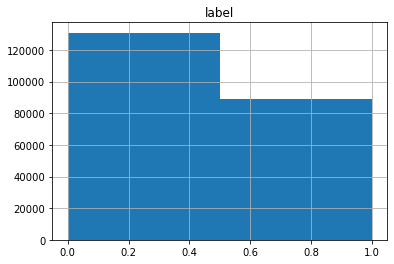

In [13]:
# Plot histagram:

data_train.hist(bins = 2);

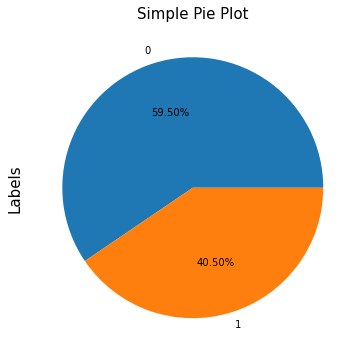

In [14]:
# Visualization:
# Plot of labels and their percentage:

plt.figure(figsize = [20,6])
labels = data_train.label.value_counts()

labels.plot(kind = 'pie',autopct = '%1.2f%%', shadow = False, startangle = 0)
plt.title('Simple Pie Plot',fontsize = 15)
plt.ylabel('Labels',fontsize = 15);

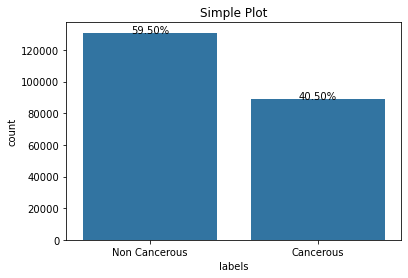

In [15]:
# Visualization:
# Plot of labels and their percentage:

color = sns.color_palette()[0]

data_train['label'] = data_train.label.replace(0, 'Non Cancerous').replace(1, 'Cancerous')

sns.countplot(data = data_train, x = 'label', color = color);
plt.title('Simple Plot');
plt.ylabel('count');
plt.xlabel('labels');

value_sum = data_train['label'].value_counts().sum()
value = data_train['label'].value_counts()

locs, labels = plt.xticks(rotation = 0) 

for loc, label in zip(locs, labels):

    count = value[label.get_text()]
    text = '{:0.2f}%'.format(100 * count/value_sum)

    plt.text(loc, count+3, text, ha = 'center', color = 'black');

In [16]:
# Dividing cancerous and non cancerous variables for further visualization:

c = np.random.choice(data_train[data_train.label == 'Cancerous'].index, size = 20, replace = False,)
nc = np.random.choice(data_train[data_train.label == 'Non Cancerous'].index, size = 20, replace = False,)

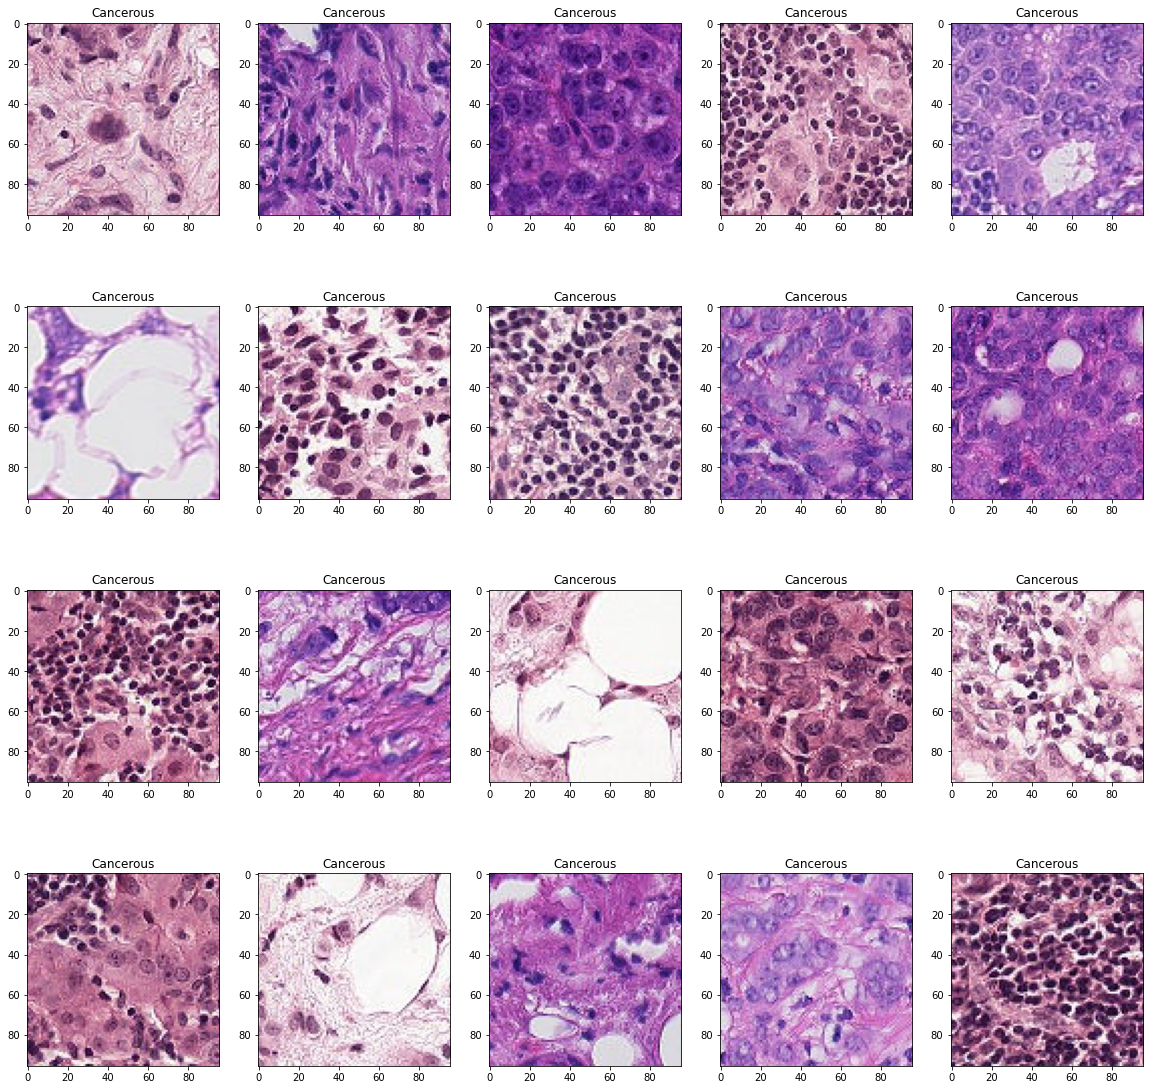

In [17]:
# Visualization of few Cancerous images:

fig, ax = plt.subplots(4, 5, figsize = (20, 20))


for i in range(4):
    for j in range(5):
        axis = c[j + 5*i]
        path = str(train + data_train.id[axis] + '.tif')
        image = mpimg.imread(path)
        ax[i,j].imshow(image)
        ax[i,j].set_title(data_train.label[axis])

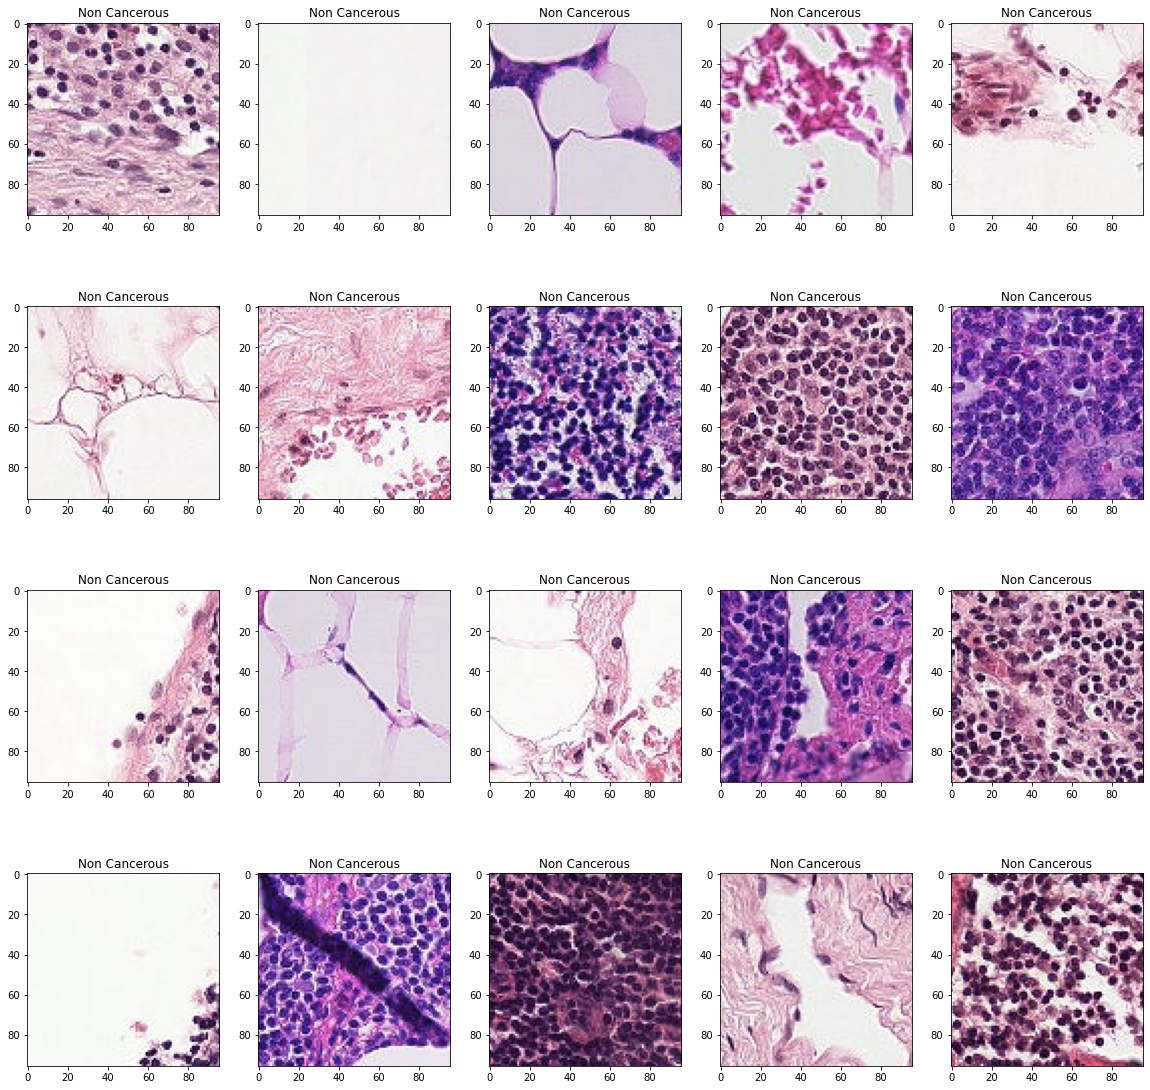

In [18]:
# Visualization of few Non Cancerous images:

fig, ax = plt.subplots(4, 5, figsize = (20, 20))


for i in range(4):
    for j in range(5):
        axis = nc[j + 5*i]
        path = str(train + data_train.id[axis] + '.tif')
        image = mpimg.imread(path)
        ax[i,j].imshow(image)
        ax[i,j].set_title(data_train.label[axis])

/opt/conda/lib/python3.7/site-packages/skimage/_shared/utils.py:348: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  return func(*args, **kwargs)


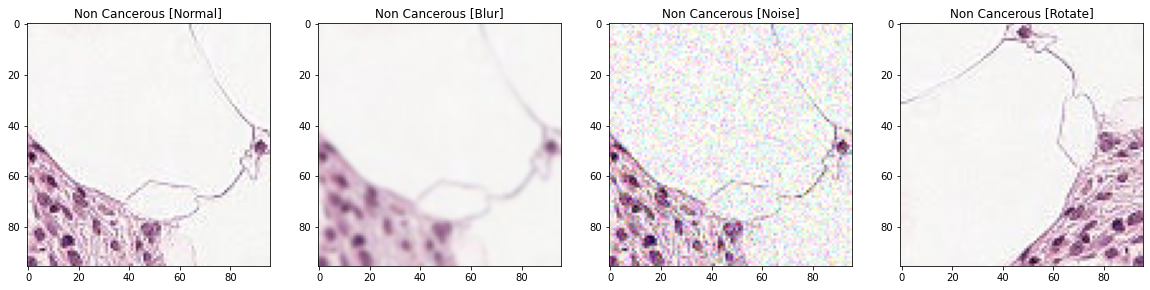

In [19]:
# Visualization a few images with blur, noise and rorate images:

plt.figure(figsize = (20, 20))

plt.subplot(1, 4, 1)
path = str(train + data_train.id[0] + '.tif')
image = mpimg.imread(path)
plt.imshow(image)
plt.title(data_train.label[0] + ' [Normal]');


plt.subplot(1, 4, 2)
g = gaussian(image)
plt.imshow(g)
plt.title(data_train.label[0] + ' [Blur]');


plt.subplot(1, 4, 3)
rn = random_noise(image)
plt.imshow(rn)
plt.title(data_train.label[0] + ' [Noise]');


plt.subplot(1, 4, 4)
r = rotate(image, 90)
plt.imshow(r)
plt.title(data_train.label[0] + ' [Rotate]');

In [20]:
# Helper function for Model Architecture:

def Add(x):
    return x + '.tif'


data_train['id'] = data_train['id'].apply(Add)
#data_train['label'] = data_train['label'].astype(str)

# Shuffle the dataset:
data_train = shuffle(data_train, random_state = 42)

data_train.head()

id          label
107796  d293308913e4a40cebb809d986aa9add65a76bfa.tif  Non Cancerous
11942   fcd55f03496afb4b11598d9c2231e86da318e723.tif      Cancerous
163858  5c983c8f14afeffdb098b9f3cbb68488a802b957.tif  Non Cancerous
184810  71bf03e8530348e57ec07d8ce2052f215390c997.tif  Non Cancerous
150958  1533406000e26663c5fadac3bcc3e38285a45bb3.tif      Cancerous

# Describe Model Architecture:

For this model we will be using Keras library to run a convolutional neural network (CNN).

The first model we will run without tuning any hyperparameters within the model and use that as our baseline. Then, we will run a second model, tuning hyperparameters such as learning rate, batch normalization, regularization, filter size, stride, activation layers, etc.

#### First model:

* Normalize images pre-training (image/255)
* Output layer activation (sigmoid)

#### Second model contains all the first model parameters, but we also add:

* Dropout (0.1)
* Batch Normalization
* Optimization (Adam)
* Learning rate (0.0001)
* Hidden layer activations (ReLU)

In [21]:
# Modify training data by normalizing it and split data into training and validation sets:

data_norm = ImageDataGenerator(rescale = 1.0/255, validation_split = 0.20)

In [22]:
# Generate training data:

gen_train = data_norm.flow_from_dataframe(data_train,
                                          directory = train,
                                          x_col = 'id',
                                          y_col = 'label',
                                          subset = 'training',
                                          batch_size = 256,
                                          class_mode = 'binary',
                                          seed = 42,
                                          target_size = (64, 64))

Found 176020 validated image filenames belonging to 2 classes.


In [23]:
# Generate testing/vadilation data:

gen_valid = data_norm.flow_from_dataframe(data_train,
                                          directory = train,
                                          x_col = 'id',
                                          y_col = 'label',
                                          subset = 'validation',
                                          batch_size = 256,
                                          class_mode = 'binary',
                                          seed = 42,
                                          target_size = (64, 64))

Found 44005 validated image filenames belonging to 2 classes.


In [24]:
# Create model:

mod = Sequential()

mod.add(Conv2D(filters = 32, kernel_size = (3, 3), input_shape = (64, 64, 3)))
mod.add(Conv2D(filters = 32, kernel_size = (3, 3), input_shape = (64, 64, 3)))
mod.add(MaxPooling2D(pool_size = (2, 2)))

mod.add(Conv2D(filters = 64, kernel_size = (3, 3), input_shape = (64, 64, 3)))
mod.add(Conv2D(filters = 64, kernel_size = (3, 3), input_shape = (64, 64, 3)))
mod.add(AveragePooling2D(pool_size = (2, 2)))

mod.add(Flatten())

mod.add(Dense(1, activation = 'sigmoid'))

# Compile model:
mod.compile(loss = 'binary_crossentropy', metrics = ['accuracy'])

# Quick look at model:
mod.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 60, 60, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 26, 26, 64)        36928     
_________________________________________________________________
average_pooling2d (AveragePo (None, 13, 13, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 10816)             0

In [25]:
# Train model:

fit = mod.fit(gen_train, epochs = 5, validation_data = gen_valid)
fit

Epoch 1/5
688/688 [==============================] - 1482s 2s/step - loss: 0.6304 - accuracy: 0.6718 - val_loss: 0.5768 - val_accuracy: 0.7333
Epoch 2/5
688/688 [==============================] - 969s 1s/step - loss: 0.5582 - accuracy: 0.7284 - val_loss: 0.5650 - val_accuracy: 0.7473
Epoch 3/5
688/688 [==============================] - 965s 1s/step - loss: 0.5301 - accuracy: 0.7480 - val_loss: 0.4857 - val_accuracy: 0.7753
Epoch 4/5
688/688 [==============================] - 980s 1s/step - loss: 0.5072 - accuracy: 0.7620 - val_loss: 0.4838 - val_accuracy: 0.7835
Epoch 5/5
688/688 [==============================] - 969s 1s/step - loss: 0.4956 - accuracy: 0.7705 - val_loss: 0.4729 - val_accuracy: 0.7894


In [26]:
# Check keys before plotting:

fit.history

{'loss': [0.630376935005188,
  0.5581660866737366,
  0.5300835371017456,
  0.507200300693512,
  0.4956456124782562],
 'accuracy': [0.67184978723526,
  0.7283604145050049,
  0.7480456829071045,
  0.7619645595550537,
  0.7705488204956055],
 'val_loss': [0.5768430233001709,
  0.5650056004524231,
  0.4857047498226166,
  0.4837997257709503,
  0.4728856682777405],
 'val_accuracy': [0.7333484888076782,
  0.747301459312439,
  0.7752528190612793,
  0.7834791541099548,
  0.7894330024719238]}

In [27]:
# Convert to DataFrame:

df = pd.DataFrame(fit.history)
df

loss  accuracy  val_loss  val_accuracy
0  0.630377  0.671850  0.576843      0.733348
1  0.558166  0.728360  0.565006      0.747301
2  0.530084  0.748046  0.485705      0.775253
3  0.507200  0.761965  0.483800      0.783479
4  0.495646  0.770549  0.472886      0.789433

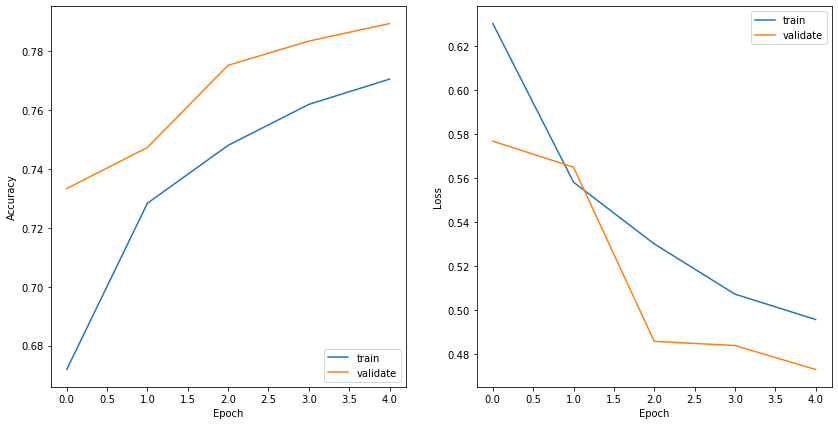

In [28]:
# Visualization:

plt.figure(figsize = (14, 7))

# Graph accuracy:
plt.subplot(1, 2, 1)
plt.plot(df['accuracy'])
plt.plot(df['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'validate'], loc = 'lower right');

# Graph loss:
plt.subplot(1, 2, 2)
plt.plot(df['loss'])
plt.plot(df['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'validate'], loc = 'upper right');

In [29]:
# Build and Train Simple Model:

model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (3, 3), strides = 1, input_shape = (64, 64, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(filters = 64, kernel_size = (3, 3), strides = 1, input_shape = (64, 64, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(filters = 64, kernel_size = (3, 3), strides = 1, input_shape = (64, 64, 3), activation = 'relu'))
model.add(AveragePooling2D(pool_size = (2, 2)))
model.add(BatchNormalization())

model.add(Dropout(0.1))

model.add(Flatten())

model.add(Dense(1, activation = 'sigmoid'))

# set optimizer with small rate:
opt = Adam(learning_rate = 0.00001)

# compile model:
model.compile(loss = 'binary_crossentropy', metrics = ['accuracy'], optimizer = opt)

# view model summary:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 31, 31, 32)        128       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 12, 12, 64)       

In [30]:
# Train model:

fit_mod = model.fit(gen_train, epochs = 5, validation_data = gen_valid)
fit_mod

Epoch 1/5
688/688 [==============================] - 584s 848ms/step - loss: 0.5645 - accuracy: 0.7212 - val_loss: 0.5284 - val_accuracy: 0.7412
Epoch 2/5
688/688 [==============================] - 578s 840ms/step - loss: 0.4858 - accuracy: 0.7739 - val_loss: 0.4477 - val_accuracy: 0.7956
Epoch 3/5
688/688 [==============================] - 582s 846ms/step - loss: 0.4545 - accuracy: 0.7926 - val_loss: 0.4260 - val_accuracy: 0.8089
Epoch 4/5
688/688 [==============================] - 580s 843ms/step - loss: 0.4327 - accuracy: 0.8052 - val_loss: 0.4097 - val_accuracy: 0.8170
Epoch 5/5
688/688 [==============================] - 586s 851ms/step - loss: 0.4171 - accuracy: 0.8144 - val_loss: 0.3977 - val_accuracy: 0.8232


In [31]:
# Check keys before plotting:

df_1 = pd.DataFrame(fit_mod.history)
df_1

loss  accuracy  val_loss  val_accuracy
0  0.564494  0.721168  0.528446      0.741234
1  0.485774  0.773906  0.447737      0.795591
2  0.454450  0.792575  0.426044      0.808908
3  0.432696  0.805193  0.409724      0.816998
4  0.417051  0.814390  0.397688      0.823156

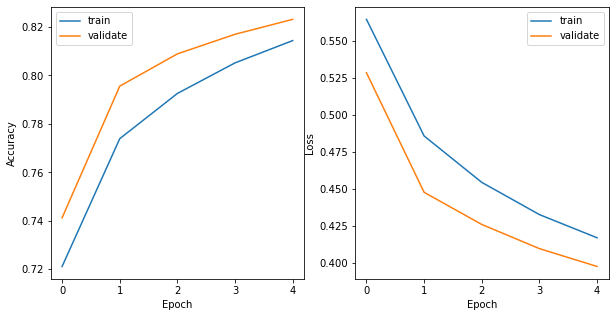

In [32]:
# Visualization:

plt.figure(figsize = (10, 5))

# Graph accuracy:
plt.subplot(1, 2, 1)
plt.plot(df_1['accuracy'])
plt.plot(df_1['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'validate']);

# Graph loss:
plt.subplot(1, 2, 2)
plt.plot(df_1['loss'])
plt.plot(df_1['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'validate']);

In [33]:
# Prediction for train dataset:

y = gen_valid.classes

y_pred = model.predict(gen_valid, verbose = 1)
y_pred = list(map(lambda x: 0 if x < 0.5 else 1, y_pred))

172/172 [==============================] - 86s 496ms/step


In [34]:
# Report:

print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.41      0.39      0.40     17828
           1       0.59      0.61      0.60     26177

    accuracy                           0.52     44005
   macro avg       0.50      0.50      0.50     44005
weighted avg       0.52      0.52      0.52     44005



[[ 6920 10908]
 [10156 16021]]


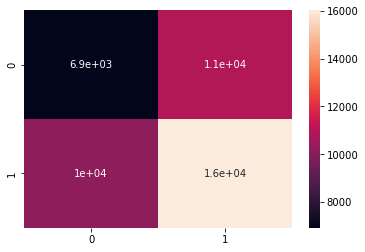

In [35]:
# Heatmap:

con_mat = confusion_matrix(y, y_pred)
print(con_mat)

sns.heatmap(con_mat, annot = True);

In [36]:
# Test dataset:

data_test = pd.DataFrame({'id': os.listdir(test)})
data_test

id
0      a7ea26360815d8492433b14cd8318607bcf99d9e.tif
1      59d21133c845dff1ebc7a0c7cf40c145ea9e9664.tif
2      5fde41ce8c6048a5c2f38eca12d6528fa312cdbb.tif
3      bd953a3b1db1f7041ee95ff482594c4f46c73ed0.tif
4      523fc2efd7aba53e597ab0f69cc2cbded7a6ce62.tif
...                                             ...
57453  7907c88a7f5f9c8ca5b2df72c1e6ff9650eea22b.tif
57454  2a6fc1ed16fa94d263efab330ccbeb1906cbd421.tif
57455  6bb5c0611c0ccf4713e0ccbc0e8c54bcb498ef14.tif
57456  f11e7c9e77cbc1ec916a52e6b871a293ee1bb928.tif
57457  66d529ceeb28e822fac5e1378cc5702194532127.tif

[57458 rows x 1 columns]

In [37]:
# Prepare test data (in same way as train data):

data_norm = ImageDataGenerator(rescale = 1.0/255)

gen_test = data_norm.flow_from_dataframe(data_test,
                                          directory = test,
                                          x_col = 'id',
                                          batch_size = 1,
                                          class_mode = None,
                                          seed = 42,
                                          target_size = (64, 64))

Found 57458 validated image filenames.


In [47]:
# Run model to find predictions:

pred = model.predict(gen_test, verbose = 1)
pred

57458/57458 [==============================] - 345s 6ms/step


array([[0.10430557],
       [0.1962806 ],
       [0.7496521 ],
       ...,
       [0.97514695],
       [0.9431454 ],
       [0.9484794 ]], dtype=float32)

In [46]:
#pred = np.transpose(pred)

test_df = data_test.id.apply(lambda x: x.split('.')[0])
test_df

0        a7ea26360815d8492433b14cd8318607bcf99d9e
1        59d21133c845dff1ebc7a0c7cf40c145ea9e9664
2        5fde41ce8c6048a5c2f38eca12d6528fa312cdbb
3        bd953a3b1db1f7041ee95ff482594c4f46c73ed0
4        523fc2efd7aba53e597ab0f69cc2cbded7a6ce62
                           ...                   
57453    7907c88a7f5f9c8ca5b2df72c1e6ff9650eea22b
57454    2a6fc1ed16fa94d263efab330ccbeb1906cbd421
57455    6bb5c0611c0ccf4713e0ccbc0e8c54bcb498ef14
57456    f11e7c9e77cbc1ec916a52e6b871a293ee1bb928
57457    66d529ceeb28e822fac5e1378cc5702194532127
Name: id, Length: 57458, dtype: object

In [43]:
# Create submission dataframe:

submission_df = pd.DataFrame({'id': test_df, 'label': list(map(lambda x: 0 if x <= 0.5 else 1, pred))})
submission_df

id  label
0      a7ea26360815d8492433b14cd8318607bcf99d9e      0
1      59d21133c845dff1ebc7a0c7cf40c145ea9e9664      1
2      5fde41ce8c6048a5c2f38eca12d6528fa312cdbb      1
3      bd953a3b1db1f7041ee95ff482594c4f46c73ed0      1
4      523fc2efd7aba53e597ab0f69cc2cbded7a6ce62      0
...                                         ...    ...
57453  7907c88a7f5f9c8ca5b2df72c1e6ff9650eea22b      1
57454  2a6fc1ed16fa94d263efab330ccbeb1906cbd421      1
57455  6bb5c0611c0ccf4713e0ccbc0e8c54bcb498ef14      1
57456  f11e7c9e77cbc1ec916a52e6b871a293ee1bb928      1
57457  66d529ceeb28e822fac5e1378cc5702194532127      0

[57458 rows x 2 columns]

1    35733
0    21725
Name: label, dtype: int64


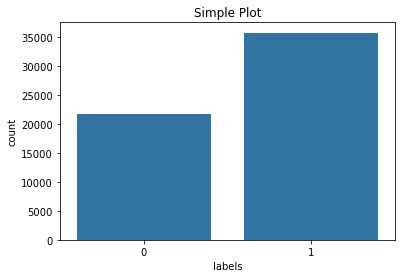

In [44]:
# Visualization of test predictions:

color = sns.color_palette()[0]

val = submission_df.label.value_counts()
print(val)

sns.countplot(data = submission_df, x = 'label', color = color);
plt.title('Simple Plot');
plt.ylabel('count');
plt.xlabel('labels');

In [45]:
# Convert to csv to submit to competition:

submission_df.to_csv('submission.csv', index = False)

# Results and Analysis:

We can see from the above plots and diagrams for each model how well they performed with the training (and validation) sets. We see that model-one seemed to steady out a bit more than our more complex model (model-two). We see in both models that the accuracy and loss does not steady. This could pertain towards the fact that we trained with very few epochs (5) and a simple CNN model with so many pictures may need more "time" to train to converge.

After submitting both trained models separately on the test set, we can see (below) how each model performed. As expected, we see that model-one (the model without hyperparameters) performed worse

## Conclusion:

Our first model was simple with no hyperparameter tuning. The second model incorporated much more tuning and a few extra layers. Both models trained for 5 epochs and performed resonably well given that they both are fairly simple. As expected, the second model did better than the first. We can see that hyperparameter tuning does indeed contribute to the model performance and can improve the model if done correctly.

Since this project is for demonstration purposes, we did not use more epochs either. Some other ideas to make a stronger model would be to  transfer learning where part of the model is taken from another well-trained model, and tune hyperparameters in different ways such as strides, filter size, activation functions, learning rate, etc, 

Thank you.